# Import the libraries and load dataset

In [1]:
#Libraries for visualisation
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd

#Libraries for handling text 
import string 
import re

#Library for nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

#Library for Splitting Dataset
from sklearn.model_selection import train_test_split

#Libraries for NN
import tensorflow as tf
from tensorflow import keras
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout , Bidirectional
from tensorflow.keras.utils import plot_model

#Library for evaluation
from sklearn import metrics
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# read the data
train = pd.read_csv("train.csv")

In [3]:
# print 5 rows of the dataset
train.head()  

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [34]:
# check missing value
train.isnull().sum()

id                 0
keyword           61
location        2533
text               0
target             0
length             0
text_cleaned       0
dtype: int64

In [4]:
# print shape of the dataset
train.shape

(7613, 5)

In [5]:
train["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

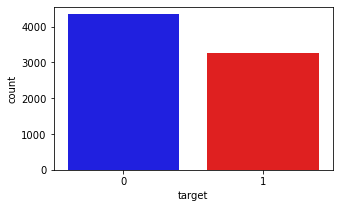

In [6]:
# Visualize the output (target)
plt.figure(figsize=(5,3))
colors = ["blue", "red"]

sns.countplot(x = 'target', data=train, palette=colors)

###  Get the top 15 locations of the data


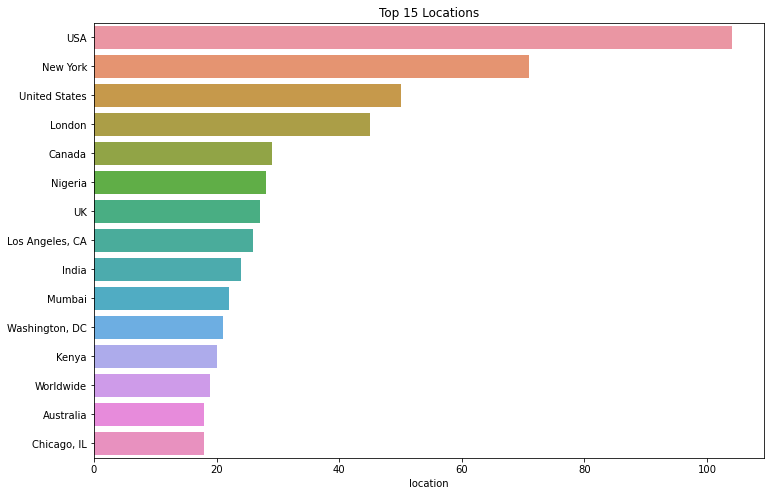

In [37]:
# Visualize the location
locations = train["location"].value_counts()
plt.figure(figsize=(12,8))
sns.barplot(y=locations[0:15].index, x=locations[0:15] , orient='h')
plt.title("Top 15 Locations")
plt.show()

### Get the top 15 keyword in the data

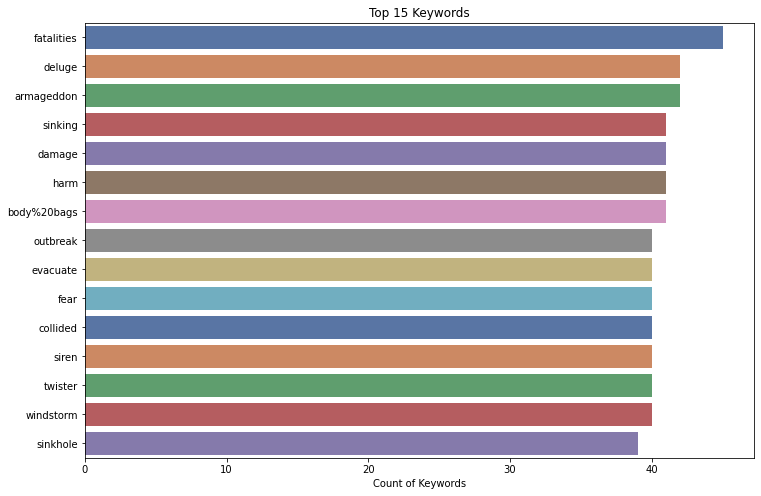

In [42]:
chains = train['keyword'].value_counts()[:15]
plt.figure(figsize=(12,8))
sns.barplot( x = chains ,y = chains.index , palette='deep')
plt.title("Top 15 Keywords")
plt.xlabel("Count of Keywords")
plt.show()

`1` we create a new column to sum the number of letters    
`2` plot the length of tweet                                                     
`3` we use pad_sequence to make all the text in the same length

In [7]:
train["length"]  = train["text"].apply(len)
train.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [8]:
# getting some statistical  
train['length'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

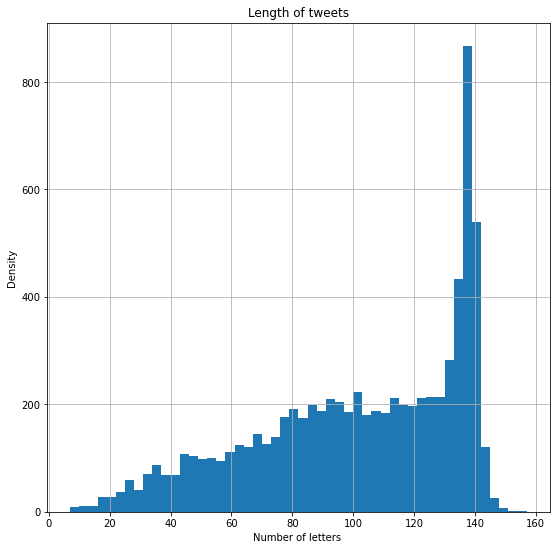

In [9]:
# plot the data
train["length"].hist( figsize=(9,9) , bins=50)
plt.title("Length of tweets")
plt.xlabel("Number of letters ")
plt.ylabel("Density")
plt.show()

# Text Preprocessing
1- Removing Punctuations

2- Removing noise

3- Removing stopwords

4- Tokenization


### 1- Removing Punctuations

In [10]:
# print the punctuation
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [11]:
def clean_text(text):
    clean_text = [char for char in text if char not in string.punctuation]
    clean_text = ''.join(clean_text)
    return clean_text


In [12]:
# create new column for clean text
train['text_cleaned'] = train['text'].apply(clean_text)

In [13]:
train.head()

,id,keyword,location,text,target,length,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,Just got sent this photo from Ruby Alaska as s...


- removed punctuation from the text 

### 2- Removing Noise 
- Noise in a text can be considered as anything which does belong to normal human language interaction.

- Noise in the text can generally be considered as URL, abbreviations, emojis, message inside HTML tag, etc. 
Punctuations can also be considered as noise. But here we have already removed punctuations.

- The main reason why abbreviations are included as noise is that some people write thx for thankyou.
If abbreviations are not replaced with the original word, 'thx' and 'thankyou' will be considered as two different words.

In [14]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [15]:
# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Remove all emojis, replace by EMOJI
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

In [16]:
def clean_tweet(text):
    
    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    
    # replace abbreviations, @ and number
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)
    
    # Remove emojis / smileys
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
  
    return text

In [17]:
train["text_cleaned"] = train["text_cleaned"].apply(clean_tweet)
train.head()

,id,keyword,location,text,target,length,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,NUMBER people receive wildfires evacuation ord...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,Just got sent this photo from Ruby Alaska as s...


### 3- Removing stopwords

- Stopwords are commonly used words that do not have features such as "a," "an," and "the," and search engines ignore them when indexing entries or retrieving search query results. Is programmed to. Saves database space and slows down processing. 
- Python's NaturalLanguageToolkit (nlkt) has a list of stopwords stored in 16 different languages. It is the leading platform for building Python programs that process human linguistic data.

In [18]:
# print stopwords 
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [19]:
def remove_stopwords(text):
    remove_stopword = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return remove_stopword

train['text_cleaned'] = train['text_cleaned'].apply(remove_stopwords)


In [20]:
train.head()

,id,keyword,location,text,target,length,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,"[Deeds, Reason, earthquake, May, ALLAH, Forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,"[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,"[NUMBER, people, receive, wildfires, evacuatio..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,"[got, sent, photo, Ruby, Alaska, smoke, wildfi..."


### 4- Tokenization
- Tokenization typically divides a text document into smaller tokens and builds a lexical word matrix. You can view the document  as a collection of words. A collection of documents is called a corpus.
1. Each Row represents a document (bag of words)
2. Each column distinct token
3. Each cell represents the frequency of occurrence of the token

In [21]:
tokenizer = Tokenizer(num_words = 3000 ,split=' ')
tokenizer.fit_on_texts(train['text_cleaned'].values) # to fit the data
x = tokenizer.texts_to_sequences(train['text_cleaned'].values) # to change words to numbers  
X = pad_sequences(x)

In [22]:
# print first
X[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,  101,    5,  132,  547, 1214])

# Apply The Model LSTM

In [23]:
# splitting text data
y = train['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =41)

In [24]:
lstm = 32
model = Sequential()
model.add(Embedding(3000 , 32 , input_length = X.shape[1]))

model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(lstm, dropout=0.5 , recurrent_dropout=0.4)))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.002)

model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            96000     
                                                                 
 dropout (Dropout)           (None, 20, 32)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 112,705
Trainable params: 112,705
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
history= model.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test) )

Epoch 1/10
191/191 [==============================] - 10s 29ms/step - loss: 0.5686 - accuracy: 0.6933 - val_loss: 0.4342 - val_accuracy: 0.8194
Epoch 2/10
191/191 [==============================] - 7s 35ms/step - loss: 0.4018 - accuracy: 0.8246 - val_loss: 0.4382 - val_accuracy: 0.8155
Epoch 3/10
191/191 [==============================] - 7s 36ms/step - loss: 0.3592 - accuracy: 0.8519 - val_loss: 0.4403 - val_accuracy: 0.8096
Epoch 4/10
191/191 [==============================] - 5s 26ms/step - loss: 0.3314 - accuracy: 0.8631 - val_loss: 0.4588 - val_accuracy: 0.8056
Epoch 5/10
191/191 [==============================] - 6s 33ms/step - loss: 0.3128 - accuracy: 0.8718 - val_loss: 0.4760 - val_accuracy: 0.8017
Epoch 6/10
191/191 [==============================] - 7s 35ms/step - loss: 0.2982 - accuracy: 0.8775 - val_loss: 0.4993 - val_accuracy: 0.7892
Epoch 7/10
191/191 [==============================] - 6s 33ms/step - loss: 0.2808 - accuracy: 0.8900 - val_loss: 0.5296 - val_accuracy: 0.787

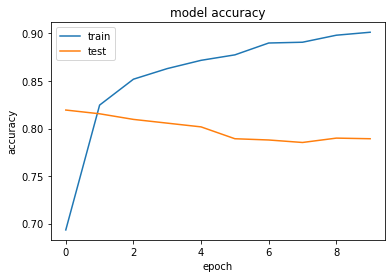

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

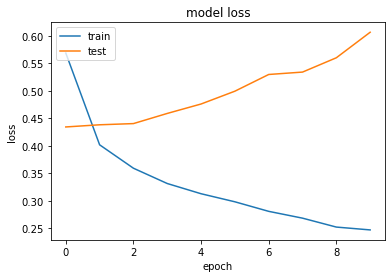

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluation Of The Model

In [28]:
y_pred = model.predict(X_test).round()
y_pred

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [29]:
train_accuracy = (metrics.accuracy_score(y_train,model.predict(X_train).round())*100)
train_accuracy

93.59605911330048

In [30]:
print('Accuracy  is  : ', (metrics.accuracy_score(y_test, y_pred)))
print('Recall  is    : ', (metrics.recall_score(y_test, y_pred)))
print('Precision  is : ', (metrics.precision_score(y_test, y_pred)))

Accuracy  is  :  0.7892317793827971
Recall  is    :  0.7286585365853658
Precision  is :  0.7697262479871175


In [31]:
conm = confusion_matrix(y_test,y_pred)
conm

array([[724, 143],
       [178, 478]], dtype=int64)

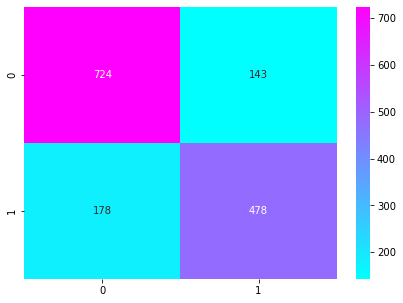

In [32]:
plt.figure(figsize=(7, 5))
sns.heatmap(conm, annot=True, fmt='d', cmap='cool')
plt.show()

In [33]:
print("the classification report ", classification_report(y_test, y_pred))

the classification report                precision    recall  f1-score   support

           0       0.80      0.84      0.82       867
           1       0.77      0.73      0.75       656

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



# Test Data 

In [48]:
test = pd.read_csv("test.csv")
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [49]:
# Apply the function to clean the data
test['text_cleaned'] = test['text'].apply(clean_text)
test["text_cleaned"] = test["text_cleaned"].apply(clean_tweet)

In [51]:
test.head()

,id,keyword,location,text,text_cleaned
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",Heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills NUMBER in China and Tai...


### New Model for test data

In [52]:
l =50
tokenizer=Tokenizer(num_words=5000 ,split=' ')
tokenizer.fit_on_texts(train['text_cleaned'].values)
x = tokenizer.texts_to_sequences(train['text_cleaned'].values)
X = pad_sequences(x, maxlen =l)

In [53]:
tokenizer.fit_on_texts(train['text_cleaned'].values)
test_token = tokenizer.texts_to_sequences(test['text_cleaned'].values)
test_token = pad_sequences(test_token, maxlen =l)

In [63]:
embed_dim = 100
lstm_out = 100
model = Sequential()
model.add(Embedding(5000 , embed_dim ,input_length = X.shape[1]))
model.add(Dropout(0.4))

model.add(Bidirectional(LSTM(100 , dropout=0.4 ,  return_sequences=True ,recurrent_dropout=0.4)))



model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(100 , dropout=0.4 , recurrent_dropout=0.2)))
model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=2e-3)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 100)           500000    
                                                                 
 dropout_14 (Dropout)        (None, 50, 100)           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 50, 200)          160800    
 nal)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 50, 200)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 200)              

In [64]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [65]:
model.fit(X,y, epochs = 10 ,validation_split = 0.2 ,callbacks=[es_callback], batch_size=32)

Epoch 1/10
191/191 [==============================] - 63s 286ms/step - loss: 0.5368 - accuracy: 0.7299 - val_loss: 0.4519 - val_accuracy: 0.7945
Epoch 2/10
191/191 [==============================] - 49s 256ms/step - loss: 0.3703 - accuracy: 0.8504 - val_loss: 0.4767 - val_accuracy: 0.7827
Epoch 3/10
191/191 [==============================] - 50s 260ms/step - loss: 0.3046 - accuracy: 0.8818 - val_loss: 0.5697 - val_accuracy: 0.7610
Epoch 4/10
191/191 [==============================] - 47s 248ms/step - loss: 0.2561 - accuracy: 0.9034 - val_loss: 0.6110 - val_accuracy: 0.7636


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

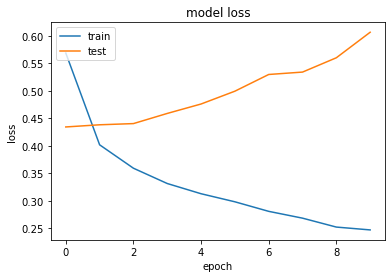

In [67]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save The Model

In [ ]:
joblib.dump(model, 'model.pkl')

In [ ]:
model = joblib.load("model.pkl")